# Vietnamese Sentiment Analysis
In this series, we will be laveraging deep learning base NLP methodologies on **Non-English language**.<br>
The interesting thing about this project is that we gets to deploy what we know as efficient models as well as DL techniques on another language, check out the efficacy of the vanilla version and then make costomizations based on the idiosyncrasy of the language of choice.<br>
We will be first looking at Vietnamese. The reason is because there are large amounts of Vietnamese article available on wikipedia that we can use for training our **language model** before actually building a classifier for *sentiment analysis*. Secondly, there is a [Vietnamese sentiment analysis competetion](https://www.aivivn.com/contests/1) available online so that we have a benchmark performance from the top competitors.

## Import relavant libraries and setup directories

In [1]:
from fastai import *
from fastai.text import *
%matplotlib inline
import os
from pathlib import Path

In [2]:
Config.data_path()

PosixPath('/home/projectx/.fastai/data')

In [3]:
data_path = Path(os.getcwd())
data_path

PosixPath('/home/projectx/Documents/Non-English sentiment analysis')

In [4]:
lang = 'vi'
name = f'{lang}wiki'
path = data_path/name
path.mkdir(exist_ok=True, parents=True)
lm_fns = [f'{lang}_wt',f'{lang}_wt_vocab']

## Create language_model trained on Vietnamese wikipedia

### Download data
Every language on wikipedia has its language representation, e.g English is 'eg'; Chinese is 'zh'; Vietnamese is 'vi'

In [5]:
# import two handy functions a help us download large corpus of datafrom wikipedia and split it later
from nlputils import split_wiki, get_wiki

In [13]:
# download our data into the path specified above
# inside `get_wiki` function we will download the data, unzip it, and keep the corpus that have minimum length of 1800
get_wiki(path, lang)

unzipping...
extracting...


In [14]:
path.ls()

[PosixPath('/home/projectx/Documents/Non-English sentiment analysis/viwiki/viwiki-latest-pages-articles.xml.bz2'),
 PosixPath('/home/projectx/Documents/Non-English sentiment analysis/viwiki/wikiextractor'),
 PosixPath('/home/projectx/Documents/Non-English sentiment analysis/viwiki/viwiki'),
 PosixPath('/home/projectx/Documents/Non-English sentiment analysis/viwiki/log'),
 PosixPath('/home/projectx/Documents/Non-English sentiment analysis/viwiki/viwiki-latest-pages-articles.xml')]

In [19]:
# This function splits the single wikipedia file into a separate file per article.
dest = split_wiki(path, lang)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000


In [20]:
# our splitted articales are stored in the /docs directory
path.ls()

[PosixPath('/home/projectx/Documents/Non-English sentiment analysis/viwiki/docs'),
 PosixPath('/home/projectx/Documents/Non-English sentiment analysis/viwiki/viwiki-latest-pages-articles.xml.bz2'),
 PosixPath('/home/projectx/Documents/Non-English sentiment analysis/viwiki/wikiextractor'),
 PosixPath('/home/projectx/Documents/Non-English sentiment analysis/viwiki/viwiki'),
 PosixPath('/home/projectx/Documents/Non-English sentiment analysis/viwiki/log'),
 PosixPath('/home/projectx/Documents/Non-English sentiment analysis/viwiki/viwiki-latest-pages-articles.xml')]

In [21]:
dest.ls()[:5]

[PosixPath('/home/projectx/Documents/Non-English sentiment analysis/viwiki/docs/Thuyết hỗ sinh.txt'),
 PosixPath('/home/projectx/Documents/Non-English sentiment analysis/viwiki/docs/Mercedes AMG.txt'),
 PosixPath('/home/projectx/Documents/Non-English sentiment analysis/viwiki/docs/Daniel Padilla.txt'),
 PosixPath('/home/projectx/Documents/Non-English sentiment analysis/viwiki/docs/Doraemon: Nobita và binh đoàn người sắt.txt'),
 PosixPath('/home/projectx/Documents/Non-English sentiment analysis/viwiki/docs/Mikhail Yuryevich Lermontov.txt')]

In [ ]:
# Use this to convert Chinese traditional to simplified characters
# ls *.txt | parallel -I% opencc -i % -o ../zhsdocs/% -c t2s.json

### Create databunch for language model

In [30]:
bs=32
data = (TextList.from_folder(dest)
            .split_by_rand_pct(0.1, seed=63)
            .label_for_lm()           
            .databunch(bs=bs))

In [31]:
data.save(f'{lang}_databunch')

In [32]:
len(data.vocab.itos), len(data.train_ds)

(60000, 66149)

In [14]:
bs=48
data = load_data(path/'docs', f'{lang}_databunch', bs=bs)
path

PosixPath('/home/projectx/Documents/Non-English sentiment analysis/viwiki')

In [15]:
data.show_batch

<bound method DataBunch.show_batch of TextLMDataBunch;

Train: LabelList (66149 items)
x: LMTextList
xxbos xxmaj thuyết hỗ sinh 
 
  xxmaj thuyết hỗ sinh hay thuyết tương sinh ( " xxmaj xxunk " ) là lý thuyết sinh học mô tả sự tương tác sinh thái giữa hai hoặc nhiều loài trong đó mỗi loài đều được hưởng lợi từ việc này . xxmaj thuyết hỗ sinh được cho là loại tương tác sinh thái phổ biến nhất và nó thường chiếm ưu thế trong hầu hết các cộng đồng trên toàn thế giới . xxmaj thuyết hỗ sinh có thể tương phản với cạnh tranh giữa các quan thể , giống loài , trong đó mỗi loài có kinh nghiệm trong việc tiến kiệm sức lực , năng lượng , và cùng khai thác tài nguyên , hoặc ký sinh trùng , trong đó một loài được hưởng lợi từ " " công sức " " của loài kia . 
  xxmaj thuật ngữ tương sinh đã được xxmaj pierre - xxmaj joseph van xxmaj xxunk giới thiệu trong cuốn sách năm 1876 của ông xxmaj ký sinh trùng và động vật . xxmaj thuyết tương sinh thường bị bó hẹp với hai loại hiện tượng sinh thái khác : hợp 

#### model details
Create language model with base-architecture being `AWD_LSTM`.<br>
As introduced in `AWD_LSTM` there are different dropout rates being applied to different layers of this architecture. The `drop_mult=0.5` means we apply only 50% of these dropout_rate.<br>
In addition, we specify `pretrained=False` so that we are not loading and pretrained weights. The model will be freshly initialized and train from scratch.

In [16]:
learn = language_model_learner(data, AWD_LSTM, drop_mult=0.5, pretrained=False).to_fp16()

In [19]:
# learn.to_fp16()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


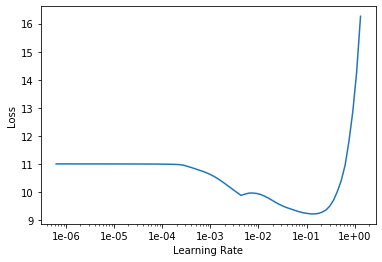

In [20]:
learn.recorder.plot()

In [21]:
# Unfreeze the model since we are not transfer learning
learn.unfreeze()
lr=1e-2
learn.fit_one_cycle(10,lr,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.373679,3.452199,0.378547,1:42:50
1,3.443367,3.513484,0.368959,1:42:14
2,3.427792,3.507759,0.370032,1:41:35
3,3.419448,3.466735,0.373973,1:41:00
4,3.387247,3.413554,0.379778,1:41:10
5,3.345488,3.354875,0.386035,1:41:02
6,3.343568,3.278793,0.395489,1:41:08
7,3.280704,3.172098,0.408634,1:41:27
8,3.200455,3.094983,0.419219,1:41:29
9,3.190851,3.067885,0.423306,1:41:38


### Model pre-training on wiki-text summary
This step is to create a pre-trained AWD_LSTM model(because FastAI doesn't come with one) so that later we can make use of it's encoder.<br>
Note that we have achieved 0.423 accuracy which means that given a sequence of words, the chance of **predicting the exact next word** is 42.3%

In [22]:
# Swtich the model back to full floating point precision
# Save the model itself
# Save the vocabulaty of the model
mdl_path = path/'models'
mdl_path.mkdir(exist_ok=True)
learn.to_fp32().save(mdl_path/lm_fns[0], with_opt=False)
learn.data.vocab.save(mdl_path/(lm_fns[1] + '.pkl'))

## Transfer learning language model on classification dataset
What we have right now, is a language model that has been trained on massive data from wikitext.<br>
The next step is to construct our classifier for **sentiment analysis**. But before that, we can perform a similar step that we have used in [our ULMFiT repo](https://github.com/Sylar257/ULMFiT-Sentiment-Analysis) to costumize our learner to this dataset we are going to use.<br>
On the high level, we just need to combine all the text we have for the *target task*, both labelled and unlabelled.Fine-tune the language model on this new corpus to learn the subtlety of the language in question in the task context. Hence, in the next a few lines of code we will be combine our training and testing text.

##### Dataset intro
As recommened by Jeremy Howard, we will be using this [Competition: comment nuances classification](https://www.aivivn.com/contests/1) which is a Vietnamese version sentiment analysis.<br>
The top 3 f1 scores are: 0.900, 0.897, 0.897

In [23]:
train_df = pd.read_csv('data/train.csv')
train_df.loc[pd.isna(train_df.comment),'comment']='NA'
train_df.head()

,id,comment,label
0,train_000000,Dung dc sp tot cam on \nshop Đóng gói sản phẩm...,0
1,train_000001,Chất lượng sản phẩm tuyệt vời . Son mịn nhưng...,0
2,train_000002,Chất lượng sản phẩm tuyệt vời nhưng k có hộp ...,0
3,train_000003,:(( Mình hơi thất vọng 1 chút vì mình đã kỳ vọ...,1
4,train_000004,Lần trước mình mua áo gió màu hồng rất ok mà đ...,1


In [24]:
test_df = pd.read_csv('data/test.csv')
test_df.loc[pd.isna(test_df.comment),'comment']='NA'
test_df.head()

,id,comment
0,test_000000,Chưa dùng thử nên chưa biết
1,test_000001,Không đáng tiềnVì ngay đợt sale nên mới mua n...
2,test_000002,Cám ơn shop. Đóng gói sản phẩm rất đẹp và chắc...
3,test_000003,Vải đẹp.phom oki luôn.quá ưng
4,test_000004,Chuẩn hàng đóng gói đẹp


In [25]:
# Combine two datasets
df = pd.concat([train_df,test_df], sort=False)

In [26]:
data_lm=(TextList.from_df(df, path, cols='comment')
         .split_by_rand_pct(0.1, seed=62)
         .label_for_lm()
         .databunch(bs=bs))

#### Create language model learner and load our pre-trained weights

In [27]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, pretrained_fnames=lm_fns, drop_mult=1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


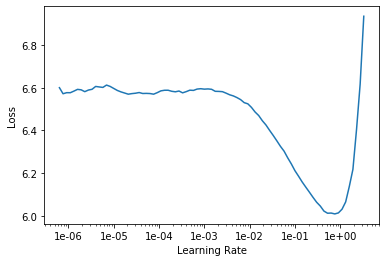

In [28]:
learn_lm.lr_find()
learn_lm.recorder.plot()

In [29]:
lr = 5e-2
learn_lm.fit_one_cycle(5, lr, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.556986,4.026099,0.333532,00:13
1,4.315544,3.961268,0.336409,00:13
2,4.172538,3.874099,0.343226,00:13
3,4.000620,3.793410,0.351233,00:13
4,3.889075,3.773175,0.353302,00:13


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


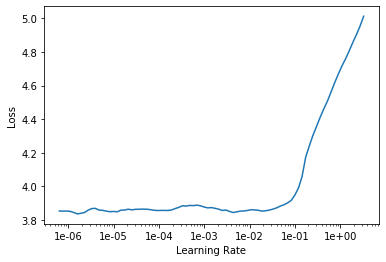

In [30]:
learn_lm.unfreeze()
learn_lm.lr_find()
learn_lm.recorder.plot()

In [31]:
lr = 2e-3
learn_lm.fit_one_cycle(10, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.771928,3.710954,0.358645,00:17
1,3.690712,3.621968,0.368041,00:17
2,3.595258,3.558721,0.374419,00:17
3,3.494357,3.516808,0.379521,00:17
4,3.416734,3.490458,0.383659,00:17
5,3.356763,3.475569,0.386664,00:17
6,3.272316,3.467713,0.388634,00:17
7,3.231916,3.463350,0.389059,00:17
8,3.212659,3.463744,0.389314,00:17
9,3.183434,3.464561,0.389371,00:17


In [32]:
# now we will save the fine-tuned language model and its encoder seperately
# later when constructing the classifier we will only be using the fine-tuned encoder
learn_lm.save(f'{lang}fine_tuned')
learn_lm.save_encoder(f'{lang}fine_tuned_enc')

In [33]:
data_clas = (TextList.from_df(train_df, path, vocab=data_lm.vocab, cols='comment')
            .split_by_rand_pct(0.1, seed=62)
            .label_from_df(cols='label') # we have labels of 0 or 1
            .databunch(bs=bs))
# this takes some time so save it and later we don't need to re-process
data_clas.save(f'{lang}_textlist_class')

In [ ]:
# load databunc
data_clas = load_data(path, f'{lang}_textlist_class', bs=bs, num_workers=1)

In [34]:
from sklearn.metrics import f1_score

@np_func
def f1(inp, targ): return f1_score(targ, np.argmax(inp, axis=-1))

#### Create text classifier and load pre-trained encoder

In [36]:
# Create learner and switch it to fp_16
learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.9, metrics=[accuracy, f1]).to_fp16()
learn_c.load_encoder(f'{lang}fine_tuned_enc')
learn_c.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


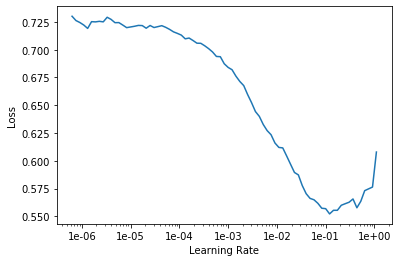

In [37]:
learn_c.lr_find()
learn_c.recorder.plot()

In [ ]:
lr = 2e-3
learn_c.fit_one_cycle(5, lr, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.377423,0.287610,0.872512,0.841924,00:08
